<a href="https://colab.research.google.com/github/Hnmani/Crack-identifier/blob/master/Crack_identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download:
Download the data from the servers.

In [3]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2020-05-05 11:38:20--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  34.5MB/s    in 73s     

2020-05-05 11:39:34 (33.9 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [0]:
!unzip -q Positive_tensors.zip 

In [0]:
# ! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

We will install torchvision:

In [0]:
!pip install torchvision

# Import packages

In [35]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [0]:
from matplotlib.pyplot import imshow
from PIL import Image
import pandas as pd
import os

# Preprocessing 


1. Define Dataset Class
2. load training and validation data set
3. Check whether GPU is available
4. Load resnet model.



In [9]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/content/"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


In [10]:
train_dataset = Dataset(train=True) #Load training data
validation_dataset = Dataset(train=False) #Load validation data
print("done")

done


Cuda is used for using GPU.

In [11]:
is_cuda = torch.cuda.is_available() 
if is_cuda:
  print("cuda available")

cuda available


In [12]:
#Load the pre-trained model resnet18
model=models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
#Setting the parameter cannot be trained for the pre-trained model
for params in model.parameters():
  params.requires_grad=False

In [0]:
#Fully connected Layeer
model.fc=nn.Linear(512,2)

In [0]:
#load model to gpu
if is_cuda:
  model = model.cuda()

In [0]:
#the loss function
criterion=nn.CrossEntropyLoss()

In [0]:
#loading data using Dataloader module of pytorch
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=100)

In [0]:
#Optimizer
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

# Learning

In [21]:
#Learning
n_epochs = 1
loss_list = []
accuracy_list = []
correct = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:

        if is_cuda:
          x , y = x.cuda(), y.cuda()  #Loads data to gpu if gpu available.

        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z = model(x)
        # calculate loss 
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
    correct = 0
    for x_test, y_test in validation_loader:
        if is_cuda:
          x_test, y_test = x_test.cuda(), y_test.cuda()
        # set model to eval 
        model.eval()
        #make a prediction 
        z=model(x_test)
        #find max 
        _,yhat=torch.max(z.data,1)
        #Calculate misclassified  samples in mini-batch 
        correct+=(yhat==y_test).sum().item()
   
    accuracy = correct / N_test



100
199
299
399
499
597
696
794
893
992
1092
1191
1291
1391
1491
1591
1687
1787
1887
1987
2087
2186
2286
2386
2486
2585
2684
2783
2882
2981
3079
3178
3277
3377
3477
3576
3676
3775
3875
3975
4075
4174
4272
4372
4470
4568
4667
4765
4862
4961
5060
5158
5258
5358
5458
5556
5655
5755
5854
5953
6053
6153
6251
6350
6450
6549
6649
6747
6847
6945
7045
7144
7243
7341
7441
7538
7637
7737
7836
7936
8036
8136
8236
8334
8432
8532
8632
8730
8830
8929
9028
9127
9226
9325
9423
9523
9622
9719
9819
9919


# Evaluation

In [25]:
print("The Accuracy on Validation set is : {}%".format(accuracy * 100))

The Accuracy on Validation set is : 99.19%


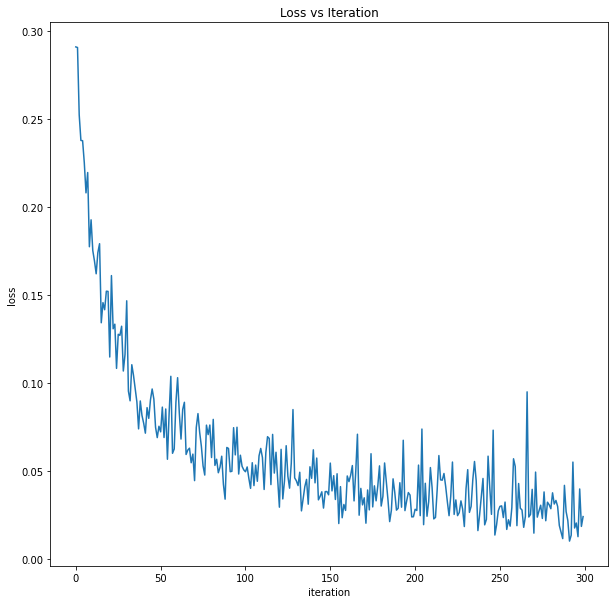

In [26]:
plt.figure(figsize=(10,10))
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Loss vs Iteration")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample 172 predicted value: 0 actual value:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample 541 predicted value: 1 actual value:0
sample 553 predicted value: 1 actual value:0
sample 656 predicted value: 0 actual value:1


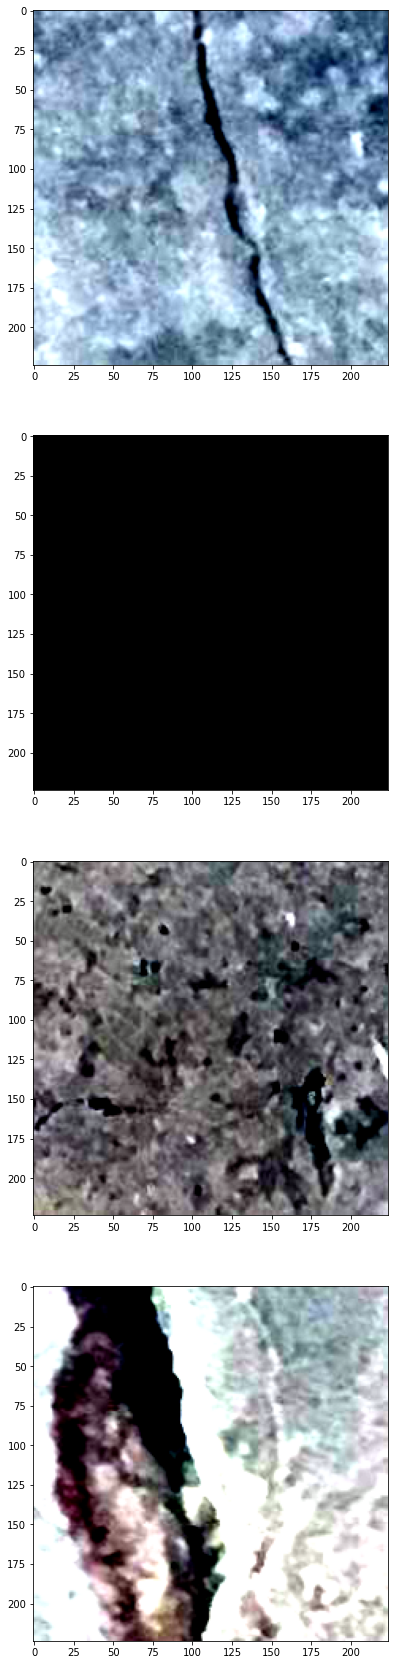

In [65]:
plt.figure(figsize=(30,30))
ax = [None,None,None,None,]
ax[0],ax[1],ax[2],ax[3] = plt.subplot(411),plt.subplot(412),plt.subplot(413),plt.subplot(414)
i=0
j = 0
correctq=0
for x_test, y_test in validation_loader: 
        if is_cuda:
          x_test = x_test.cuda()
        model.eval() 
        z=model(x_test)
        _,yhat=torch.max(z.data,1)
        t=False
        for pred,act in zip(yhat,y_test):
          if pred!=act:
            ax[j].imshow(x_test[i%100].cpu().T);
            print("sample {} predicted value: {} actual value:{}".format(i,pred,act))
            j+=1
            if j==4:
              t=True
              break
          i+=1
        if t:
          break
plt.show()

In [0]:
# torch.save(model,"./harsh.pkl") #model saved

torch.Size([100, 3, 224, 224])

# Test